In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

In [3]:
## If this file doesn't exist you need to generate it with `examples/cossim_across_folders.sh`
folder = '../../../../results/NAPvsMP/NAPvsMPlines/cossim_df.pickle'

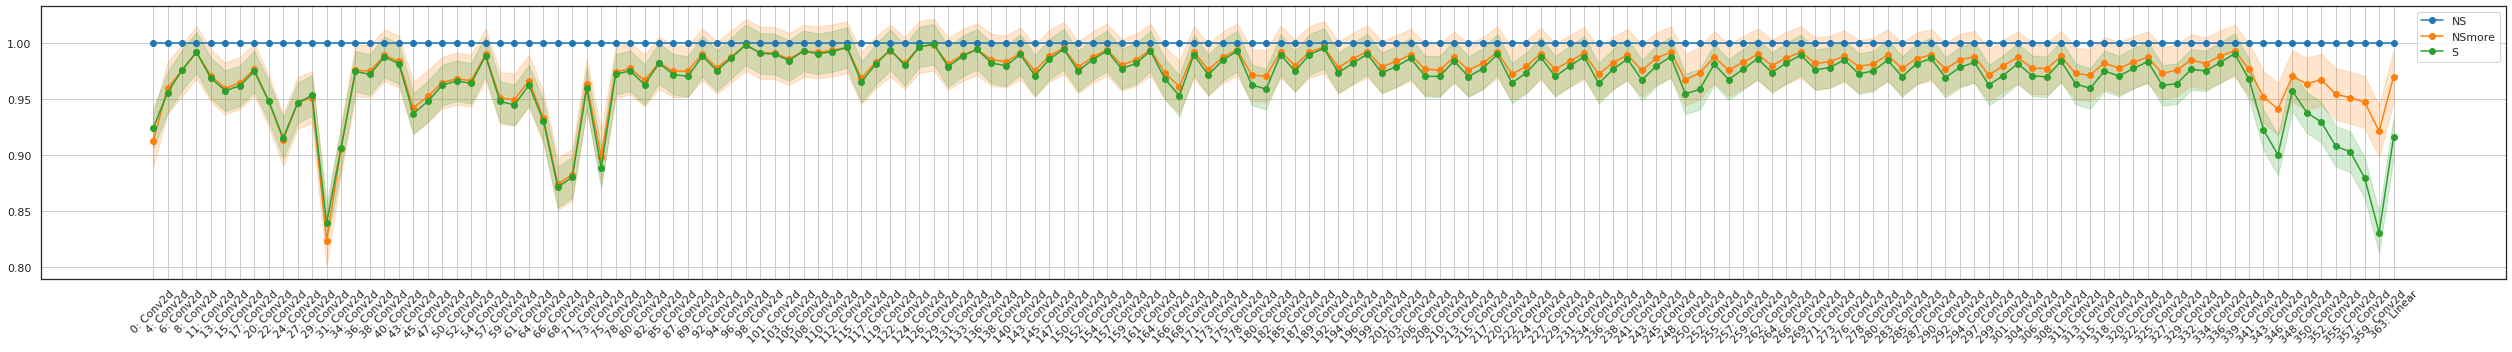

In [4]:
color_cycle = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color']*3)
result_folder = os.path.dirname(folder)

## Sample Analyises, you can just delete all of this if you want
pk = pickle.load(open(folder, 'rb'))
cossim_df, layers_names = pk['cossim_df'], pk['layers_names']
cossim_ll = cossim_df[['level'] + layers_names]
m = cossim_ll.groupby('level').mean()
std = cossim_ll.groupby('level').std()
len(cossim_df['set'].unique())

## Plot All Together
import seaborn as sns
plt.close('all')
sns.set(style='white')
plt.subplots(1, 1, figsize=(35, 5))
levels = m.index.get_level_values('level')
for idx, l in enumerate(levels):
    plt.plot(m.loc[l],  color=color_cycle[idx], marker='o', label=l)
    plt.fill_between(range(len(m.loc[l])), m.loc[l] - std.loc[l][idx], m.loc[l] + std.loc[l][idx], alpha=0.2, color=color_cycle[idx])

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.savefig(result_folder + '/plot_layers.png')


In [12]:
## Perform One Way ANOVA
import scipy.stats as stats
r = stats.f_oneway(*[cossim_df[layers_names[-1]][cossim_df['level'] == i] for i in cossim_df['level'].unique()])
with open(result_folder + '/stats_output.txt', 'w') as o:
    o.write(f'One Way Anova: p-value={r.pvalue}\n')

In [13]:
## Perform the repeated measures ANOVA
try:
    from statsmodels.stats.anova import AnovaRM
    r = AnovaRM(data=cossim_df, depvar=layers_names[-1], subject='set', within=['level'], aggregate_func='mean').fit()
    with open(result_folder + '/stats_output.txt', 'a') as o:
        o.write("Repeated Measures ANOVA:\n")
        o.write(str(r.anova_table))
    print(r.summary())
except:
    pass

               Anova
      F Value Num DF  Den DF Pr > F
-----------------------------------
level 15.8477 2.0000 50.0000 0.0000



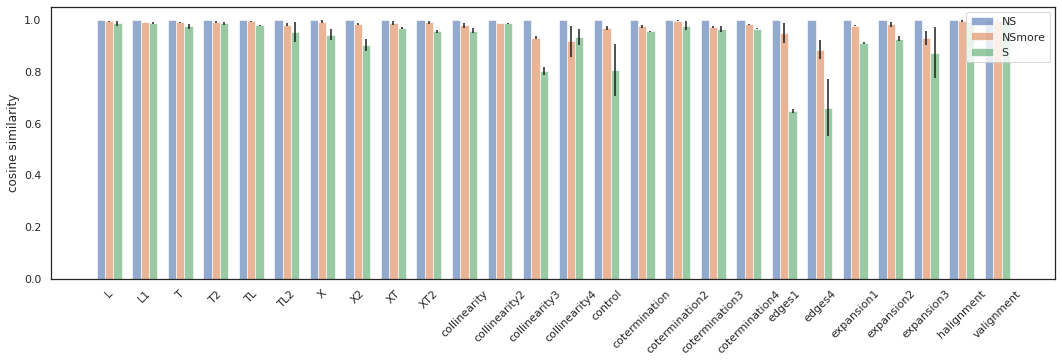

In [14]:
## Barplot
plt.close('all')
m = cossim_df.groupby(['level', 'set'])[layers_names[-1]].mean()
s = cossim_df.groupby(['level', 'set'])[layers_names[-1]].std()
levels = m.index.get_level_values('level').unique()
color_cycle = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])
plt.subplots(1, 1, figsize=(18, 5))

for idx, l in enumerate(levels):
    span = 0.7
    width = span / (len(levels))
    i = np.arange(0, len(m.loc[l]))
    rect = plt.bar(np.arange(len(m.loc[l])) - span / 2
                   + width/2 + width * idx, m.loc[l], width, yerr=s.loc[l], label=l, color=color_cycle[idx], alpha=0.6)

plt.ylabel('cosine similarity')
plt.xticks(range(len(m.loc[l])), m.loc[l].index, rotation=45)
plt.legend()
plt.savefig(result_folder + '/barplot.png')
